# 8. 비지도 학습
## 8.4 생성적 적대 신경망

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#/content/gdrive/My Drive/pytorch_dlbro

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=False),
            nn.ReLU(True),           
            nn.ConvTranspose2d(256, 128, 3, 2, bias=False),
            nn.ReLU(True), 
            nn.ConvTranspose2d(128, 64, 3, 2, bias=False),
            nn.ReLU(True),   
            nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=False),
            nn.Tanh())
           
    def forward(self, x):
        x = x.view(-1, self.n_features, 1, 1)
        x = self.conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv =  nn.Sequential(
                    nn.Conv2d(1, 128, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2), 
                    nn.Dropout(0.5),        
                    nn.Conv2d(128, 256, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2),     
                    nn.Dropout(0.5),
                    nn.Conv2d(256, 256, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True),    
                    nn.Dropout(0.5),
                    nn.Conv2d(256, 1, 3, 2, bias=False), 
                    nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv(x)
        return x.view(-1,1)

## 11.3 손실함수 및 최적화 방법 정의

In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc_dcgan.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner_dcgan.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

## 11.4 학습 전략 정의

In [7]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    
    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()
    
    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

## 11.5 학습하기

In [8]:
test_noise = noise(64)
l = len(trainloader)

for epoch in range(301):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))
       
torch.save(discriminator.state_dict(), './models/fmnist_disc_dcgan.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner_dcgan.pth')    

Epoch 0: g_loss: 0.853 d_loss: 0.794
Epoch 10: g_loss: 0.720 d_loss: 0.773
Epoch 20: g_loss: 0.709 d_loss: 0.813
Epoch 30: g_loss: 0.701 d_loss: 0.849
Epoch 40: g_loss: 0.708 d_loss: 0.868
Epoch 50: g_loss: 0.705 d_loss: 0.883
Epoch 60: g_loss: 0.729 d_loss: 0.879
Epoch 70: g_loss: 0.737 d_loss: 0.876
Epoch 80: g_loss: 0.732 d_loss: 0.882
Epoch 90: g_loss: 0.734 d_loss: 0.892
Epoch 100: g_loss: 0.747 d_loss: 0.888
Epoch 110: g_loss: 0.740 d_loss: 0.899
Epoch 120: g_loss: 0.746 d_loss: 0.898
Epoch 130: g_loss: 0.741 d_loss: 0.901
Epoch 140: g_loss: 0.744 d_loss: 0.903
Epoch 150: g_loss: 0.742 d_loss: 0.915
Epoch 160: g_loss: 0.748 d_loss: 0.917
Epoch 170: g_loss: 0.750 d_loss: 0.922
Epoch 180: g_loss: 0.744 d_loss: 0.930
Epoch 190: g_loss: 0.748 d_loss: 0.926
Epoch 200: g_loss: 0.755 d_loss: 0.924
Epoch 210: g_loss: 0.755 d_loss: 0.931
Epoch 220: g_loss: 0.762 d_loss: 0.925
Epoch 230: g_loss: 0.761 d_loss: 0.930
Epoch 240: g_loss: 0.752 d_loss: 0.937
Epoch 250: g_loss: 0.755 d_loss: 0.9

In [9]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items_dc.gif', imgs)

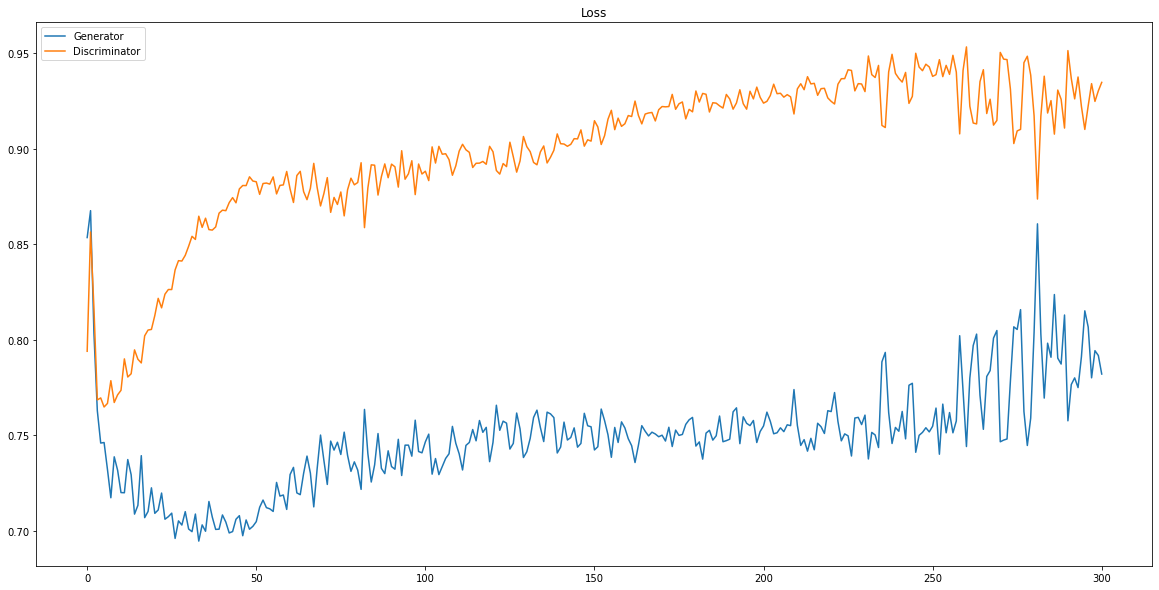

In [10]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

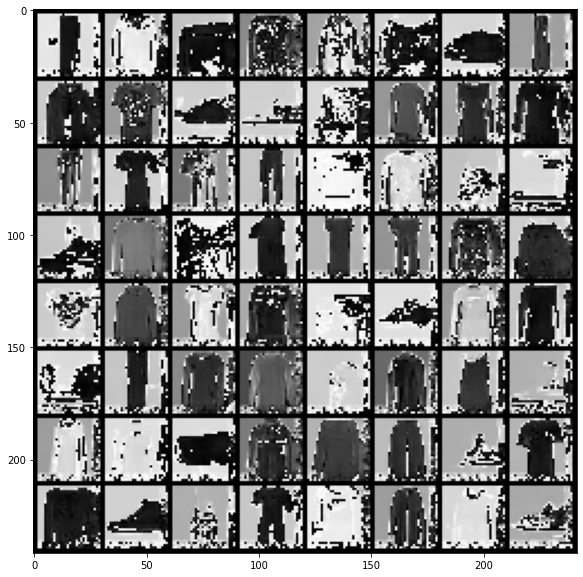

In [11]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()